<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/pix2pixNDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2pix para segmentado de imagenes NDVI


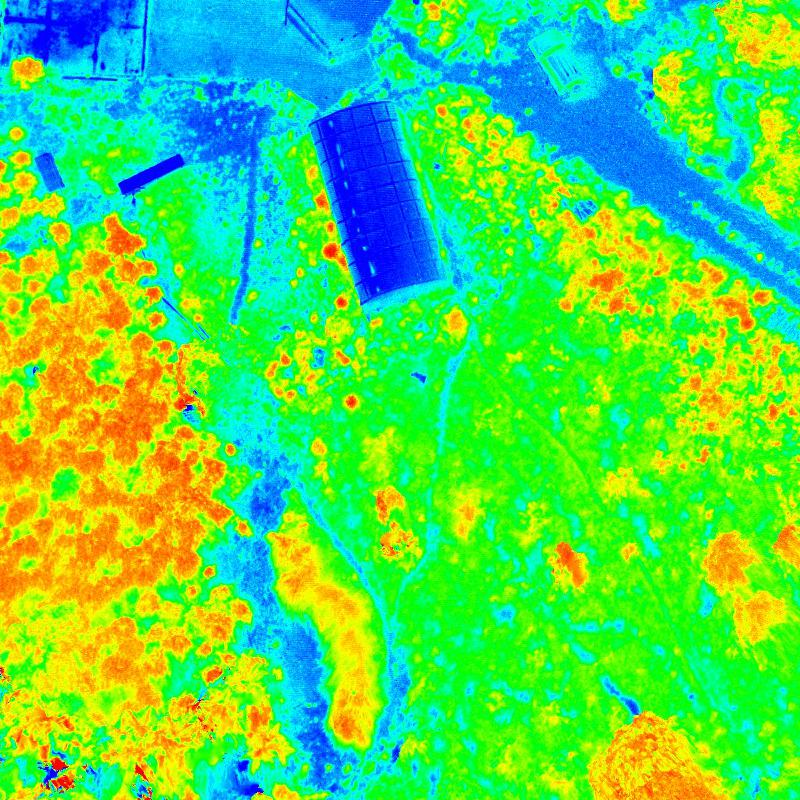



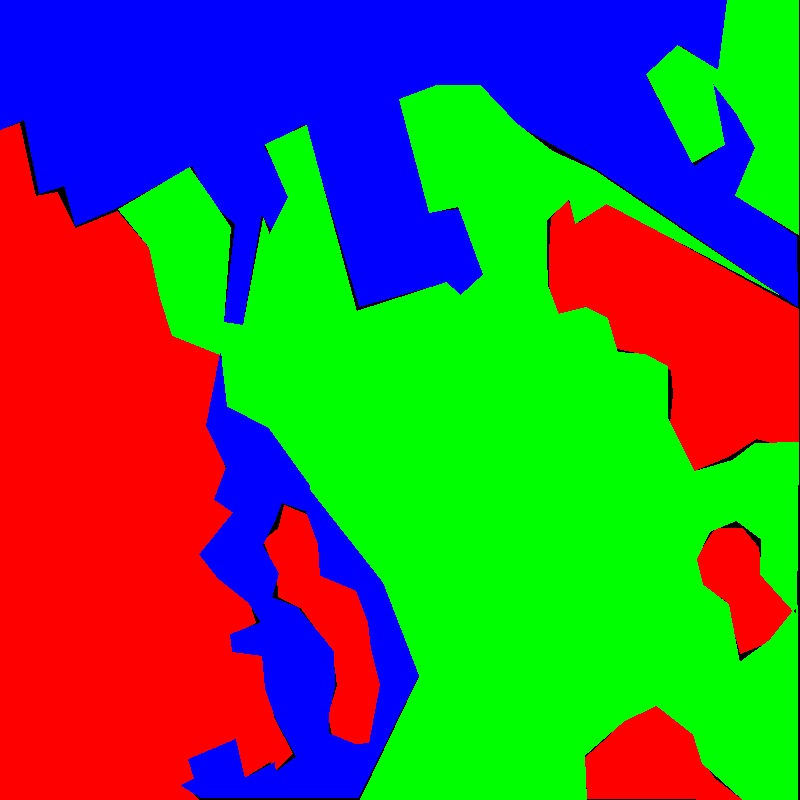{ width: 200px; }

## Librerias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tensorflow.keras.models import load_model

In [2]:
# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/pix2pix"

# Ruta de datos de entrada
INPATH = PATH + '/imagenes_ndvi/'
# Ruta de salida
OUTPATH = PATH + '/imagenes_segmentadas/'
# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

## Listar Archivos

In [3]:
def ls_path(path, filtro="*.jpg"):
    spath=path + filtro
    a=glob(spath)
    return     

In [4]:
#imgurls = ls_path(INPATH)
imgurls = !ls -1 "{INPATH}"

## Particionar Dataset

In [5]:
 n = len(imgurls)
 train_n = round(n*0.8)
 
 # Particion Train/Test
 tr_urls = imgurls[:train_n]
 ts_urls = imgurls[train_n:n]

In [6]:
print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 301 
 Entrenamiento: 241 
 Testeo: 60 


## Funciones de preprocesado de imagenes

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg):
    inimg = (inimg/127.5)-1
    tgimg = (tgimg/127.5)-1

    return inimg,tgimg

@tf.function()
# Aumentación de datos: Random Crop + Flip
def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

# carga de imagenes dataset
def load_image(filename, augment=True):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)),tf.float32)
    
    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    if augment:
        inimg,tgimg = random_jitter(inimg,tgimg)
    
    inimg,tgimg = normalize(inimg,tgimg)
    return inimg,tgimg

def load_train_image(filename):
    return load_image(filename,True)

def load_test_image(filename):
    return load_image(filename,False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


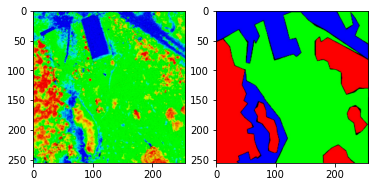

In [8]:
[ndvi,ndvi_seg] = load_train_image(tr_urls[0])
plt.subplot(121)
plt.imshow(ndvi)
plt.subplot(122)
plt.imshow(ndvi_seg)
plt.show()

## Creación de Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


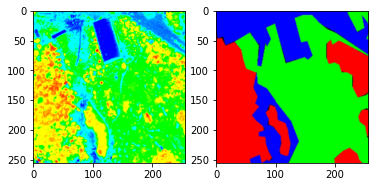

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


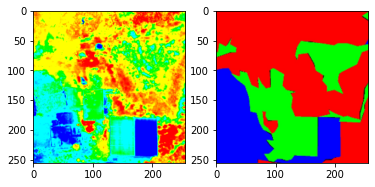

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inimg, tgimg in train_dataset.take(2):
    plt.subplot(121)
    plt.imshow(np.squeeze(inimg)+1/2)
    plt.subplot(122)
    plt.imshow((np.squeeze(tgimg)+1)/2)
    plt.show()

## Crear Generador

In [10]:
from tensorflow.keras.layers import *

from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):
  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # capa convolucional
  result.add(Conv2D(filters,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias = not apply_batchnorm))

  # Capa de BatchNormalization
  result.add(BatchNormalization())

  # Capa de Activacion
  result.add(LeakyReLU())

  return result

downsample(64)

In [11]:
def upsample(filters, apply_dropout=False):
  result = Sequential()

  initializer = tf.random_normal_initializer(0,0.02)

  # capa convolucional
  result.add(Conv2DTranspose(filters,
                             kernel_size = 4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias = False))

  # Capa de BatchNormalization
  result.add(BatchNormalization())

  if apply_dropout:
    result.add(Dropout(0.5))

  # Capa de Activacion
  result.add(ReLU())

  return result
upsample(64)

In [12]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
                downsample(64,apply_batchnorm=False),   # (bs,256,256,64)
                downsample(128),                        # (bs,128,128,128)
                downsample(256),                        # (bs,64,64,256)
                downsample(512),                        # (bs,32,32,512)
                downsample(512),                        # (bs,16,16,512)
                downsample(512),                        # (bs,8,8,512)
                downsample(512),                        # (bs,4,4,512)
                downsample(512),                        # (bs,2,2,512)
  ]

  up_stack = [
              upsample(512,apply_dropout=True),
              upsample(512,apply_dropout=True),
              upsample(512,apply_dropout=True),
              upsample(512),
              upsample(256),
              upsample(128),
              upsample(64),

  ]

  initializer = tf.random_normal_initializer(0,0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation = "tanh")
  
  x = inputs
  s = []
  concat = Concatenate()

  # Conectar capas de Encoder
  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  # Conectar capas Decoder
  for up, sk in zip(up_stack,s):
    x = up(x)
    x = concat([x,sk])

  last = last(x)

  return Model(inputs=inputs,outputs=last)
generator= Generator()

## Observando Respuesta del generador sin entrenamiento

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


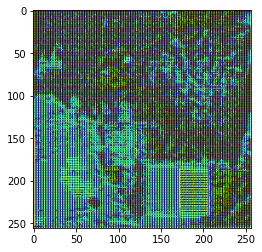

In [17]:
gen_output = generator(((inimg+1)*255),training =False)
plt.imshow(gen_output[0,...])
plt.show()

In [18]:
def Discriminator():
  ini = Input(shape=[None, None, 3], name = "input_img")
  gen = Input(shape=[None, None, 3], name = "generator_img")
  con = concatenate([ini,gen])

  initializer = tf.random_normal_initializer(0,0.02)

  down1 = downsample(64,apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=3,
                                kernel_size=4,
                                strides = 1,
                                kernel_initializer=initializer,
                                padding="same")(down4)

  return tf.keras.Model(inputs=[ini,gen],outputs=last)

discriminator = Discriminator()

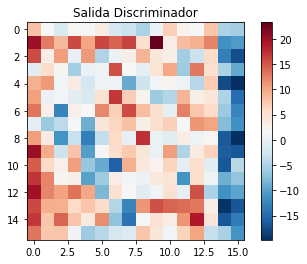

Tamaño salida discriminador: (1, 16, 16, 3)


In [19]:
disc_out = discriminator([((inimg+1)*255),gen_output],training=False)
plt.figure()
#plt.imshow(disc_out[0,...,-1], vmin=-20,vmax=20, cmap='RdBu_r')
plt.imshow(disc_out[0,...,-1], cmap='RdBu_r')
plt.title('Salida Discriminador')
plt.colorbar()
plt.show()
print("Tamaño salida discriminador:",disc_out.shape)

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  
  # Diferencia entre los true por ser real y el detectado por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [21]:
LAMBDA = 100 # Valor de ajuste para ponderar pesos

def generator_loss(disc_generated_output,gen_output,target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss

In [22]:
import os

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
def generate_images(model, test_input, tar,save_filename=True,display_images=True):
  prediction = model(test_input, training=True)
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH+'/output/'+save_filename+'.jpg',prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0,...], tar[0,...], prediction[0,...]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(PATH+'/output/'+save_filename+'_sp'+'.jpg')
  plt.show()

In [24]:
@tf.function()
def train_step(input_image,target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training =True)

    output_gen_discr = discriminator([output_image,input_image],training=True)

    output_trg_discr = discriminator([target,input_image],training=True)

    discr_loss = discriminator_loss(output_trg_discr,output_gen_discr)

    gen_loss = generator_loss(output_gen_discr,output_image,target)

    generator_grads = gen_tape.gradient(gen_loss,generator.trainable_variables)

    discriminator_grads = discr_tape.gradient(discr_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))

In [25]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      print('epoch:'+str(epoch)+' - train: '+str(imgi)+ '/'+str(len(tr_urls)))
      imgi +=1
      train_step(input_image,target)

      clear_output(wait=True)
    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator,inp,tar, str(imgi)+'_'+str(epoch),display_images=True)
      imgi +=1

      # save a checkpoint
      if (epoch+1)%200 ==0:
        checkpoint.save(file_prefix=checkpoint_prefix)

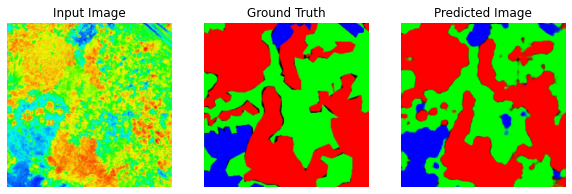

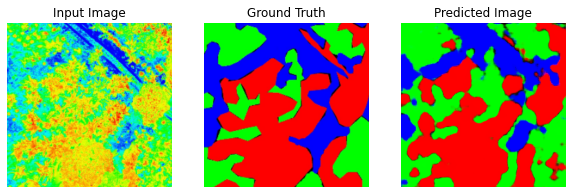

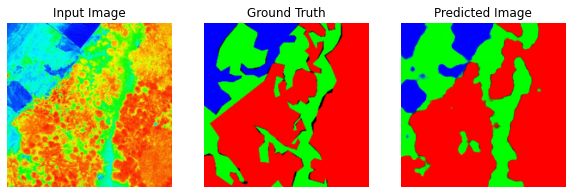

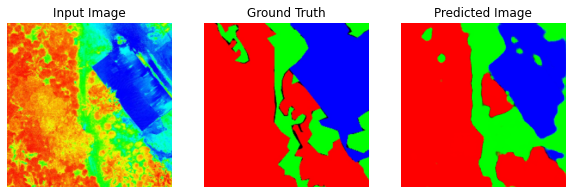

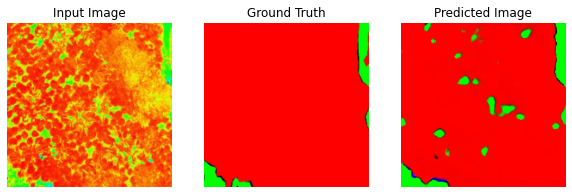

In [26]:
train(train_dataset,10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


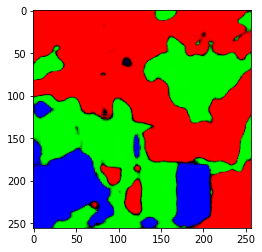

In [30]:
prediction = generator(inimg, training=True)
plt.imshow(prediction[0,...])
plt.show()

In [31]:
generator.save("model.h5")

In [32]:
model=load_model("model.h5")
#model=generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


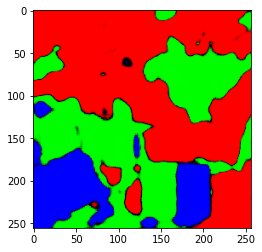

In [33]:
prediction = model(inimg, training=True)
plt.imshow(prediction[0,...])
plt.show()